# Автоматическая оценка конструкций по степени некомпозициональности

In [1]:
import pandas as pd
import numpy as np
from pymorphy2 import MorphAnalyzer
from gensim.models import KeyedVectors
from scipy.spatial import distance
from tqdm.notebook import tqdm
from razdel import sentenize, tokenize
from navec import Navec
from slovnet import Morph
import os
from pathlib import Path
from string import punctuation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

## Препроцессинг

In [194]:
punctuation = punctuation + '«' + '»'

In [195]:
data = pd.read_csv('final_noncomp_dataset.tsv', sep='\t', index_col=0

In [196]:
def cleaner(stri):
    return ''.join([s.lower() for s in stri if s not in punctuation])


data['head'] = data['head'].apply(lambda s: cleaner(s))
data['dep'] = data['dep'].apply(lambda s: cleaner(s))

senteces = data.drop_duplicates(subset=['sent'])['sent'].to_list()

### Приведение токенов к виду, соответствующему словарю векторной модели 

In [198]:
navec = Navec.load('../navec_news_v1_1B_250K_300d_100q.tar')
morph = Morph.load('../slovnet_morph_news_v1.tar', batch_size=4)
morph.navec(navec)

morphAn = MorphAnalyzer()

In [199]:
chunk = []
for sent in senteces:
    tokens = [_.text for _ in tokenize(sent)]
    chunk.append(tokens)

In [200]:
def normal_forms(w, pos):    
    for an in morphAn.parse(w):
        if str(an.tag.POS) == pos:
            return an.normal_form
    return morphAn.parse(w)[0].normal_form


pos_dict = {}
for i, c in tqdm(enumerate(chunk)):
    markup = next(morph.map([c]))
    for token in markup.tokens:
        word = token.text.lower()
        if word not in pos_dict:
            pos_dict[token.text.lower()] = (f'{normal_forms(word, token.pos)}_{token.pos}')

In [203]:
def dict_checker(word):
    if word in pos_dict:
        return pos_dict[word]
    else:
        return np.nan

In [208]:
def creating_bigram(head, dep, lemma_head, lemma_dep, sent):
    sent = cleaner(sent)
    sent = sent.split(' ')
    lemma_head = lemma_head.split('_')
    lemma_dep = lemma_dep.split('_')
    if sent.index(head) < sent.index(dep):
        return lemma_head[0] + '::' + lemma_dep[0] + '_' + lemma_head[1] + lemma_dep[1]
    else:
        return lemma_dep[0] + '::' + lemma_head[0] + '_' + lemma_dep[1] + lemma_head[1]

In [209]:
data['lemma_head'] = data['head'].apply(lambda w: dict_checker(w))
data['lemma_dep'] = data['dep'].apply(lambda w: dict_checker(w))
data = data.dropna()
data['construction'] = data.apply(lambda row: creating_bigram(row['head'],
                                                              row['dep'],
                                                              row['lemma_head'], 
                                                              row['lemma_dep'],
                                                              row['sent']), axis=1)

## Семантическая композиция

In [211]:
wv = KeyedVectors.load_word2vec_format('ruwikiruscorpora_superbigrams_2_1_2.vec')

In [466]:
def vectorization(w):
    try:
        return wv[w]
    except:
        return np.nan

In [502]:
def synt_vector(head, dep, constr):
    vec_head = vectorization(head)
    vec_dep = vectorization(dep)
    vec_constr = vectorization(constr)
    if (vec_head is not None) and (vec_dep is not None) and (vec_constr is not None):
        sum_components = np.add(vec_head, vec_dep)
        synt = np.subtract(vec_constr, (sum_components / 2))
        return synt
    else:
        return None

Получение "синтаксического вектора". Типы, участвующие в эксперименте: `amod`, `case`, `nmod`, `nsubj`, `obl`, `advmod`, `obj`.

In [503]:
compositional = data[data['SCORE'] == '0']
synt_types = ['amod', 'case', 'nmod', 'nsubj', 'obl', 'advmod', 'obj']

In [506]:
synt_vectors = {}
for st in synt_types:
    data_filtered = compositional[compositional['type'] == st]
    data_filtered = data_filtered[['lemma_head', 
                                   'lemma_dep', 
                                   'construction']].to_dict('records')
    synt_vecs = []
    for record in data_filtered:
        vec = synt_vector(record['lemma_head'],
                          record['lemma_dep'],
                          record['construction'])
        if vec is not None:
            synt_vecs.append(vec)
    if synt_vecs != []:
        synt_vectors[st] = np.mean(synt_vecs, axis=0)
    else:
        synt_vectors[st] = np.nan

In [508]:
experimental = data[(data['type'] == 'amod') |
                    (data['type'] == 'nmod') |
                    (data['type'] == 'nsubj') |
                    (data['type'] == 'obl') |
                    (data['type'] == 'advmod') |
                    (data['type'] == 'obj')]

In [726]:
def non_compositionality(head, dep, constr, stype):
    vec_head = vectorization(head)
    vec_dep = vectorization(dep)
    vec_constr = vectorization(constr)
    if (vec_head is not None) and (vec_dep is not None) and (vec_constr is not None):
        sum_components = np.add(vec_head, vec_dep)
        synt_comp = np.subtract(vec_constr, (sum_components / 2))
        nComp = np.subtract(synt_comp, synt_vectors[stype])
        return nComp
    else:
        return np.nan

Получение "вектора композиционального компонента". Нормализация таргетов.

In [728]:
experimental['nCompVector'] = experimental.apply(lambda row: non_compositionality(row['lemma_head'],
                                                                                  row['lemma_dep'],
                                                                                  row['construction'],
                                                                                  row['type']), axis=1)

experimental_notna = experimental.dropna()
experimental_notna['SCORE'] = experimental_notna['SCORE'].apply(int)
experimental_notna['norm_score'] = normalize([experimental_notna['SCORE'].to_list()], axis=1, norm='max')[0]

## Линейная регрессия. Подсчет метрик

In [970]:
X_train, X_test, y_train, y_test = train_test_split(experimental_notna['nCompVector'].to_list(),
                                                    experimental_notna['norm_score'], 
                                                    test_size=0.2, random_state=7)

reg = LinearRegression().fit(X_train, 
                             y_train)
print(f'MSE = {round(mean_squared_error(y_test, reg.predict(X_test)), 2)}')
print(f'MAE = {round(mean_absolute_error(y_test, reg.predict(X_test)), 2)}')

In [977]:
predictions = pd.DataFrame(y_test)
predictions['preds'] = reg.predict(X_test).tolist()
predictions['preds'] = predictions['preds'].apply(lambda s: round(s, 2))
output = pd.merge(experimental_notna, predictions, left_index=True, right_index=True)
output.to_csv('regression_points.tsv', sep = '\t')

### График

<Figure size 1200x800 with 0 Axes>

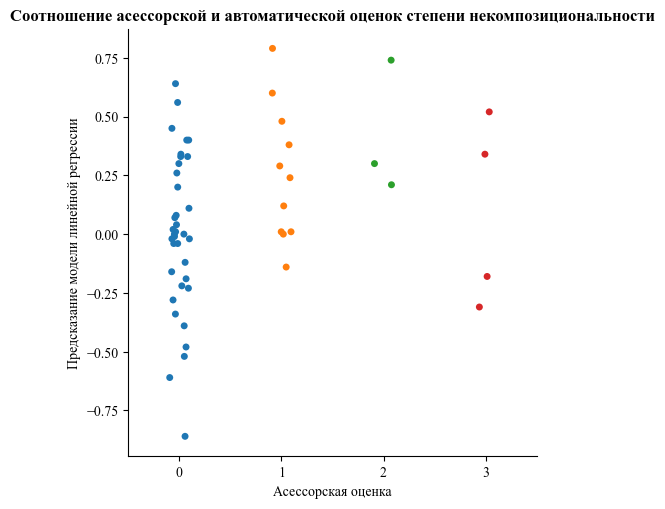

In [995]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.figure(figsize=(12, 8))
p = sns.catplot(x="SCORE", y="preds", data=output)
plt.title('Соотношение асессорской и автоматической оценок степени некомпозициональности',fontweight='bold')
plt.xlabel('Асессорская оценка')
plt.ylabel('Предсказание модели линейной регрессии')
plt.savefig('regression_results.png', bbox_inches='tight')

Полученный маленький размеченный автоматически датасет.

In [996]:
output

,id_sent,head,dep,SCORE,type,sent,lemma_head,lemma_dep,construction,nCompVector,norm_score_x,norm_score_y,preds
14,0,подобная,книге,0,obl,Музей деревянного зодчества молод-- ему всего ...,подобный_ADJ,книга_NOUN,подобный::книга_ADJNOUN,"[0.021596251, -0.010277153, 0.0068787, 0.07749...",0.000000,0.000000,-0.48
31,1,прокурору,области,0,nmod,Сотрудница канцелярии вскрыла одно из писем --...,прокурор_NOUN,область_NOUN,прокурор::область_NOUNNOUN,"[0.042454287, -0.07194653, 0.052688237, -0.074...",0.000000,0.000000,-0.52
57,7,доме,детском,2,amod,В конце прошлого года она провела в подмосковн...,дом_NOUN,детский_ADJ,детский::дом_ADJNOUN,"[-0.014379878, -0.020702928, 0.04249776, 0.013...",0.666667,0.666667,0.74
136,17,повышения,благосостояния,1,nmod,Покуда наш президент готовился послать Федерал...,повышение_NOUN,благосостояние_NOUN,повышение::благосостояние_NOUNNOUN,"[0.07275029, -0.063274026, -0.06913576, -0.007...",0.333333,0.333333,0.01
164,17,происходили,события,0,nsubj,Покуда наш президент готовился послать Федерал...,происходить_VERB,событие_NOUN,происходить::событие_VERBNOUN,"[0.020542584, -0.022842001, -0.0006249137, -0....",0.000000,0.000000,0.01
275,42,населения,местного,0,amod,Носителями одной из поздних региональных культ...,население_NOUN,местный_ADJ,местный::население_ADJNOUN,"[-0.016175877, -0.003353428, -0.023794241, 0.0...",0.000000,0.000000,-0.19
330,46,проекта,резолюции,0,nmod,Ответ заместителя министра иностранных дел Рос...,проект_NOUN,резолюция_NOUN,проект::резолюция_NOUNNOUN,"[0.019560289, 0.038792975, -0.07026527, -0.015...",0.000000,0.000000,0.33
370,55,основе,технологии,1,nmod,В метаноловых элементах питания на основе техн...,основа_NOUN,технология_NOUN,основа::технология_NOUNNOUN,"[-0.05785271, -0.03758003, 0.01829324, -0.0175...",0.333333,0.333333,0.01
419,63,услуг,связи,0,nmod,"По прогнозу аналитиков Pyramid Research, коли...",услуга_NOUN,связь_NOUN,услуга::связь_NOUNNOUN,"[0.020381287, 0.03352297, -0.061054766, -0.046...",0.000000,0.000000,0.64
438,65,случай,удивительный,0,amod,Удивительный случай имел место в бурятском гор...,случай_NOUN,удивительный_ADJ,удивительный::случай_ADJNOUN,"[-0.014097378, 0.03423957, -0.020144735, -0.00...",0.000000,0.000000,-0.61
